Импорт библиотек

In [ ]:
# установка библиотеки для скачивания из гугл диска
!pip install gdown

In [ ]:
import os
import csv
import gzip
import shutil
import collections
import re
import io
import json
import xml.etree.ElementTree as ET
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import gdown
import gc

## Извлечение данных

Данные:
*   молекулы+лекарства из https://go.drugbank.com/drugs
*   https://go.drugbank.com/releases/latest#full
*   академическая лицензия
*   подаём в модель: биохимические свойства молекул
*   предсказываем: pKa Константа диссоциации (насколько быстро молекула распадётся в организме)



In [ ]:
# Загружаем с гуглдиска (или сайта) базу
url = 'https://drive.google.com/uc?id=1soxxUj70pIxZe1Tg2T7AeAEmn7hSPXuC'
output = 'full_database.xml.gz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1soxxUj70pIxZe1Tg2T7AeAEmn7hSPXuC
To: /content/full_database.xml.gz
100%|██████████| 151M/151M [00:01<00:00, 102MB/s]


'full_database.xml.gz'

In [ ]:
# Извлекаем данные из базы
xml_path = 'full_database.xml.gz'
with gzip.open(xml_path) as xml_file:
    tree = ET.parse(xml_file)
root = tree.getroot()

ns = '{http://www.drugbank.ca}'
for i,drug in enumerate(root):
    row = collections.OrderedDict()
    assert drug.tag == ns + 'drug'

ns = '{http://www.drugbank.ca}'
# calculated properties
cal_logp_template = "{ns}calculated-properties/{ns}property[{ns}kind='logP']/{ns}value"
cal_logs_template = "{ns}calculated-properties/{ns}property[{ns}kind='logS']/{ns}value"
cal_ws_template = "{ns}calculated-properties/{ns}property[{ns}kind='Water Solubility']/{ns}value"
cal_mw_template = "{ns}calculated-properties/{ns}property[{ns}kind='Molecular Weight']/{ns}value"
cal_psa_template = "{ns}calculated-properties/{ns}property[{ns}kind='Polar Surface Area (PSA)']/{ns}value"
cal_refr_template = "{ns}calculated-properties/{ns}property[{ns}kind='Refractivity']/{ns}value"
cal_pola_template = "{ns}calculated-properties/{ns}property[{ns}kind='Polarizability']/{ns}value"
cal_rbc_template = "{ns}calculated-properties/{ns}property[{ns}kind='Rotatable Bond Count']/{ns}value"
cal_hdac_template = "{ns}calculated-properties/{ns}property[{ns}kind='H Bond Acceptor Count']/{ns}value"
cal_hbdc_template = "{ns}calculated-properties/{ns}property[{ns}kind='H Bond Donor Count']/{ns}value"
cal_pkasa_template = "{ns}calculated-properties/{ns}property[{ns}kind='pKa (strongest acidic)']/{ns}value"
cal_pkasb_template = "{ns}calculated-properties/{ns}property[{ns}kind='pKa (strongest basic)']/{ns}value"
cal_pc_template = "{ns}calculated-properties/{ns}property[{ns}kind='Physiological Charge']/{ns}value"
cal_nr_template = "{ns}calculated-properties/{ns}property[{ns}kind='Number of Rings']/{ns}value"
cal_bioa_template = "{ns}calculated-properties/{ns}property[{ns}kind='Bioavailability']/{ns}value"
cal_rof_template = "{ns}calculated-properties/{ns}property[{ns}kind='Rule of Five']/{ns}value"
# experimental properties
exp_mw_template = "{ns}experimental-properties/{ns}property[{ns}kind='Molecular Weight']/{ns}value"
exp_logp_template = "{ns}experimental-properties/{ns}property[{ns}kind='logP']/{ns}value"
exp_pka_template = "{ns}experimental-properties/{ns}property[{ns}kind='pKa']/{ns}value"

rows = list()
for i, drug in enumerate(root):
    row = collections.OrderedDict()
    assert drug.tag == ns + 'drug'
    row['type'] = drug.get('type')
    row['drugbank_id'] = drug.findtext(ns + "drugbank-id[@primary='true']")
    row['name'] = drug.findtext(ns + "name")
    row['state'] = drug.findtext(ns + "state")
    row['cal_logp'] = drug.findtext(cal_logp_template.format(ns = ns))
    row['cal_logs'] = drug.findtext(cal_logs_template.format(ns = ns))
    row['cal_water_solubility'] = drug.findtext(cal_ws_template.format(ns = ns))
    row['cal_molecular_weight'] = drug.findtext(cal_mw_template.format(ns = ns))
    row['cal_polar_surface_area'] = drug.findtext(cal_psa_template.format(ns = ns))
    row['cal_refractivity'] = drug.findtext(cal_refr_template.format(ns = ns))
    row['cal_polarizability'] = drug.findtext(cal_pola_template.format(ns = ns))
    row['cal_rotatable_bond_count'] = drug.findtext(cal_rbc_template.format(ns = ns))
    row['cal_h_bond_acceptor_count'] = drug.findtext(cal_hdac_template.format(ns = ns))
    row['cal_h_bond_donor_count'] = drug.findtext(cal_hbdc_template.format(ns = ns))
    row['cal_pka_acidic'] = drug.findtext(cal_pkasa_template.format(ns = ns))
    row['cal_pka_basic'] = drug.findtext(cal_pkasb_template.format(ns = ns))
    row['cal_physiological_charge'] = drug.findtext(cal_pc_template.format(ns = ns))
    row['cal_number_of_rings'] = drug.findtext(cal_nr_template.format(ns = ns))
    row['cal_bioavailability'] = drug.findtext(cal_bioa_template.format(ns = ns))
    row['cal_rule_of_five'] = drug.findtext(cal_rof_template.format(ns = ns))
    row['exp_molecular_weight'] = drug.findtext(exp_mw_template.format(ns = ns))
    row['exp_logp'] = drug.findtext(exp_logp_template.format(ns = ns))
    row['exp_pka'] = drug.findtext(exp_pka_template.format(ns = ns))
    row['half_life'] = drug.findtext(ns + "half-life")
    rows.append(row)

# combine multiple values of the same feature
def collapse_list_values(row):
    for key, value in row.items():
        if isinstance(value, list):
            row[key] = '|'.join(value)
    return row

rows = list(map(collapse_list_values, rows))
drugbank_df = pd.DataFrame.from_dict(rows)
drugbank_df.head()

# сохраняем в файл
drugbank_df.to_csv(path_or_buf='drugbank_halflife.tsv', sep='\t', index=False)



In [ ]:
# очистка оперативной памяти, тк у бесплатного google colab на неё ограничение, которого мы достигли (справа сверху значёк ОЗУ)
del tree
del root
gc.collect()

0

## Изучение данных

In [ ]:
drugbank_df = pd.read_csv('drugbank_halflife.tsv', sep='\t')
drugbank_df.head(20)

,type,drugbank_id,name,state,cal_logp,cal_logs,cal_water_solubility,cal_molecular_weight,cal_polar_surface_area,cal_refractivity,...,cal_pka_acidic,cal_pka_basic,cal_physiological_charge,cal_number_of_rings,cal_bioavailability,cal_rule_of_five,exp_molecular_weight,exp_logp,exp_pka,half_life
0,biotech,DB00001,Lepirudin,liquid,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6963.425,NaN,NaN,Approximately 1.3 hours
1,biotech,DB00002,Cetuximab,liquid,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,145781.600,NaN,NaN,After administration of a 400 mg/m<sup>2</sup>...
2,biotech,DB00003,Dornase alfa,liquid,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29253.900,NaN,NaN,NaN
3,biotech,DB00004,Denileukin diftitox,liquid,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,57647.300,NaN,NaN,70-80 min
4,biotech,DB00005,Etanercept,liquid,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,51234.900,NaN,NaN,Etanercept has a mean half-life of elimination...
5,small molecule,DB00006,Bivalirudin,solid,-0.76,-4.7,4.64e-02 g/l,2180.2853,901.57,543.33,...,2.78,11.88,-4.0,6.0,0.0,0.0,NaN,NaN,NaN,* Normal renal function: 25 min (in normal con...
6,small molecule,DB00007,Leuprolide,solid,1.04,-4.6,3.38e-02 g/l,1209.3983,429.04,327.24,...,9.49,11.92,1.0,6.0,0.0,0.0,NaN,NaN,9.6,Leuprolide has a terminal elimination half-lif...
7,biotech,DB00008,Peginterferon alfa-2a,liquid,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60000.000,NaN,NaN,The mean terminal half-life of peginterferon a...
8,biotech,DB00009,Alteplase,liquid,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,59042.300,NaN,NaN,NaN
9,biotech,DB00010,Sermorelin,liquid,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3357.882,NaN,NaN,11-12 min


In [ ]:
# количество молекул полного датасета
len(drugbank_df)

14594

In [ ]:
# количество NaN в каждом свойстве
drugbank_df.isna().sum(axis=0)/len(drugbank_df)

type                         0.000000
drugbank_id                  0.000000
name                         0.000000
state                        0.375223
cal_logp                     0.225915
cal_logs                     0.258599
cal_water_solubility         0.258599
cal_molecular_weight         0.225709
cal_polar_surface_area       0.226120
cal_refractivity             0.226120
cal_polarizability           0.226394
cal_rotatable_bond_count     0.226120
cal_h_bond_acceptor_count    0.226120
cal_h_bond_donor_count       0.226120
cal_pka_acidic               0.349048
cal_pka_basic                0.282445
cal_physiological_charge     0.226257
cal_number_of_rings          0.226120
cal_bioavailability          0.226120
cal_rule_of_five             0.225572
exp_molecular_weight         0.981362
exp_logp                     0.899137
exp_pka                      0.958133
half_life                    0.841921
dtype: float64

In [ ]:
#типы фитч
drugbank_df['cal_water_solubility'] = drugbank_df.cal_water_solubility.str.replace(' g/l','').astype(float)
drugbank_df.dtypes

type                          object
drugbank_id                   object
name                          object
state                         object
cal_logp                     float64
cal_logs                     float64
cal_water_solubility         float64
cal_molecular_weight         float64
cal_polar_surface_area       float64
cal_refractivity             float64
cal_polarizability           float64
cal_rotatable_bond_count     float64
cal_h_bond_acceptor_count    float64
cal_h_bond_donor_count       float64
cal_pka_acidic               float64
cal_pka_basic                float64
cal_physiological_charge     float64
cal_number_of_rings          float64
cal_bioavailability          float64
cal_rule_of_five             float64
exp_molecular_weight         float64
exp_logp                     float64
exp_pka                       object
half_life                     object
dtype: object

In [ ]:
# основные характеристики фитч
drugbank_df.describe()

,cal_logp,cal_logs,cal_water_solubility,cal_molecular_weight,cal_polar_surface_area,cal_refractivity,cal_polarizability,cal_rotatable_bond_count,cal_h_bond_acceptor_count,cal_h_bond_donor_count,cal_pka_acidic,cal_pka_basic,cal_physiological_charge,cal_number_of_rings,cal_bioavailability,cal_rule_of_five,exp_molecular_weight,exp_logp
count,11297.000000,10820.000000,10820.000000,11300.000000,11294.000000,11294.000000,11290.000000,11294.000000,11294.000000,11294.000000,9500.000000,10472.000000,11292.000000,11294.000000,11294.000000,11302.000000,2.720000e+02,1472.000000
mean,1.808705,-3.385928,23.966139,388.626904,104.054617,99.836090,38.555685,6.408890,5.409687,2.690189,8.466496,2.697092,-0.112115,2.663450,0.846821,0.749513,2.366842e+05,3.612545
std,2.669337,1.738364,105.941863,331.690302,128.787502,80.115735,31.290255,9.034855,6.167052,4.161733,5.432188,5.745086,1.222195,2.242015,0.360176,0.433312,1.707777e+06,62.657073
min,-62.000000,-9.400000,0.000000,2.016000,0.000000,0.000000,0.440000,0.000000,0.000000,0.000000,-12.000000,-10.000000,-13.000000,0.000000,0.000000,0.000000,5.900000e+01,-13.200000
25%,0.110000,-4.600000,0.010600,246.301900,53.020000,61.857500,23.660000,3.000000,3.000000,1.000000,3.507500,-2.900000,-1.000000,1.000000,1.000000,0.000000,1.988145e+04,0.400000
50%,2.060000,-3.600000,0.084400,343.421900,83.120000,91.670000,35.130000,5.000000,4.000000,2.000000,9.210000,3.140000,0.000000,3.000000,1.000000,1.000000,6.325000e+04,2.050000
75%,3.540000,-2.200000,1.860000,444.602000,116.760000,118.170000,45.227500,8.000000,6.000000,3.000000,12.710000,8.360000,1.000000,4.000000,1.000000,1.000000,1.460000e+05,3.412500
max,12.870000,1.200000,1400.000000,8272.338000,3617.470000,1931.710000,735.410000,176.000000,191.000000,116.000000,20.000000,21.850000,12.000000,69.000000,1.000000,1.000000,2.000000e+07,2400.000000


Text(0.5, 1.0, 'cal_pka_acidic')

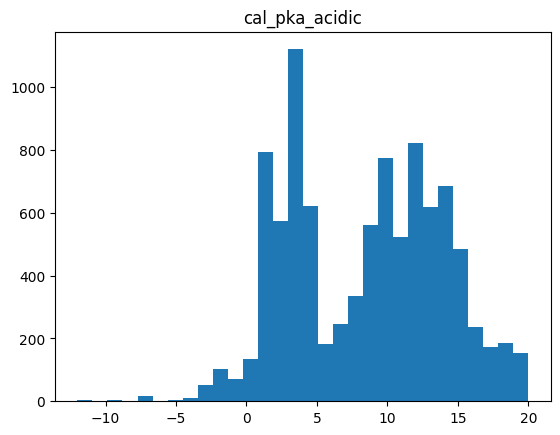

In [ ]:
# пример гистограммы по cal_pka_acidic, которую будем предсказывать
plt.hist(drugbank_df['cal_pka_acidic'], bins=30)
plt.title('cal_pka_acidic')

In [ ]:
# берём только числовые фитчи для регрессии
cols_to_analyse= list(set(drugbank_df.columns) - set(['type', 'drugbank_id', 'name', 'half_life', 'exp_pka', 'exp_logp', 'exp_molecular_weight']))

cal_bioavailability
cal_pka_acidic
cal_refractivity
cal_rule_of_five
cal_polar_surface_area
cal_h_bond_donor_count
cal_h_bond_acceptor_count
cal_pka_basic
cal_number_of_rings
cal_logp
cal_molecular_weight
cal_polarizability
cal_physiological_charge
cal_logs
cal_rotatable_bond_count


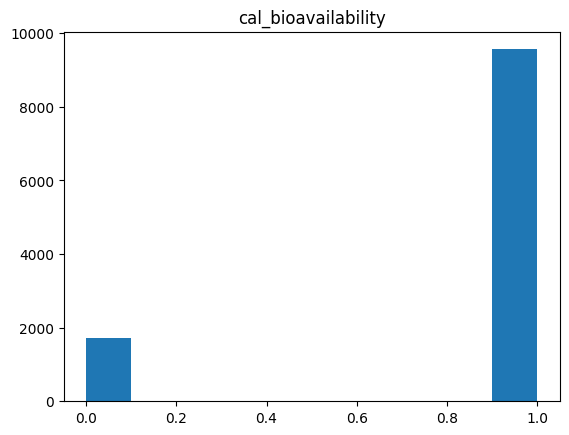

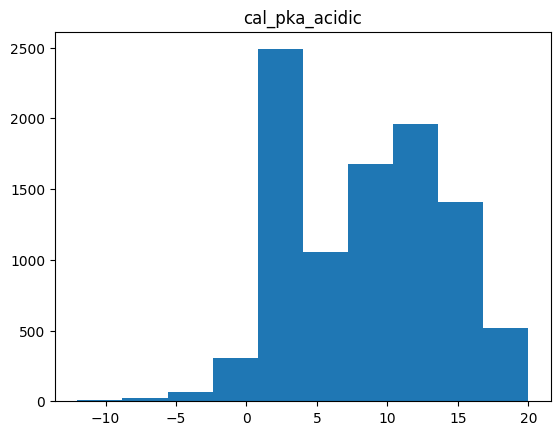

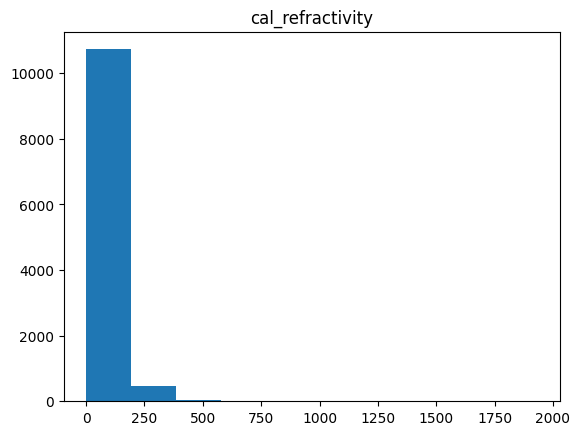

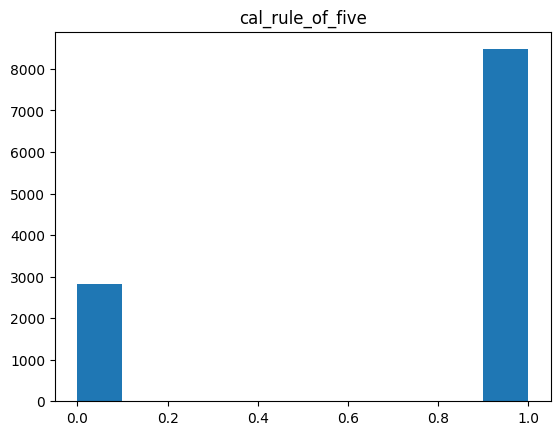

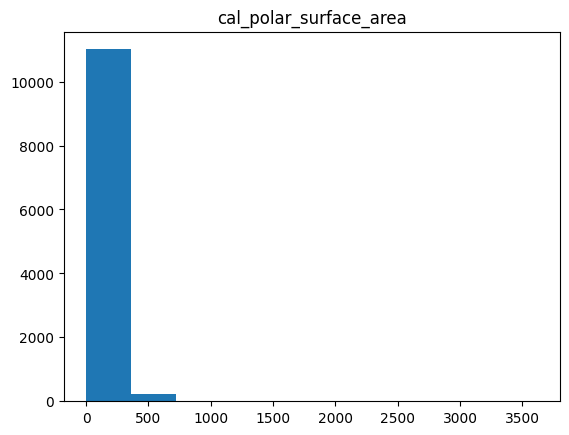

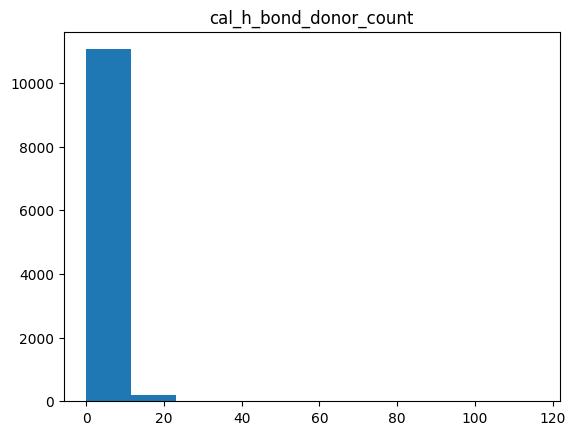

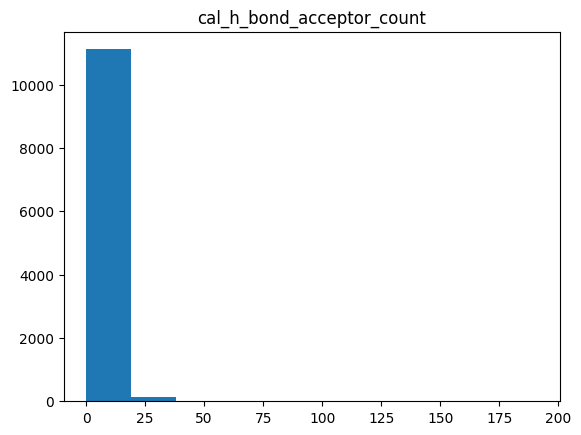

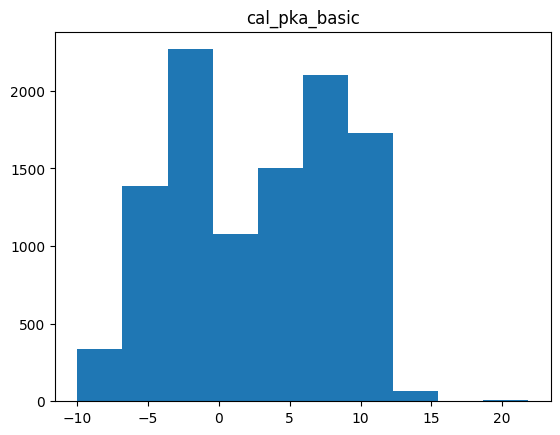

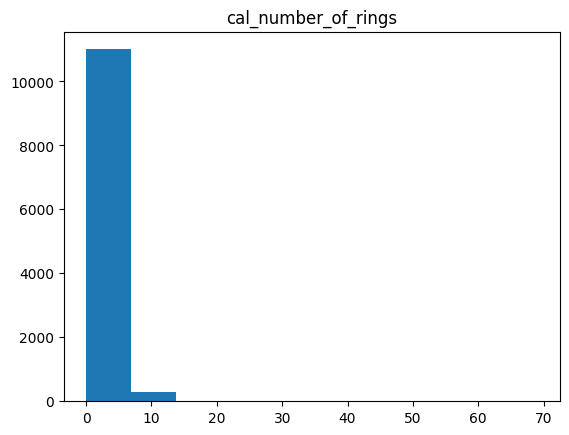

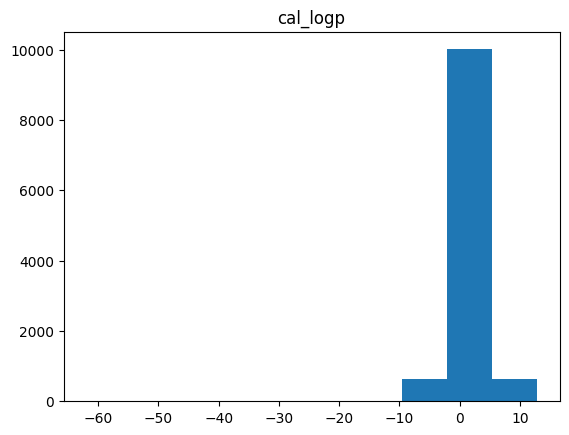

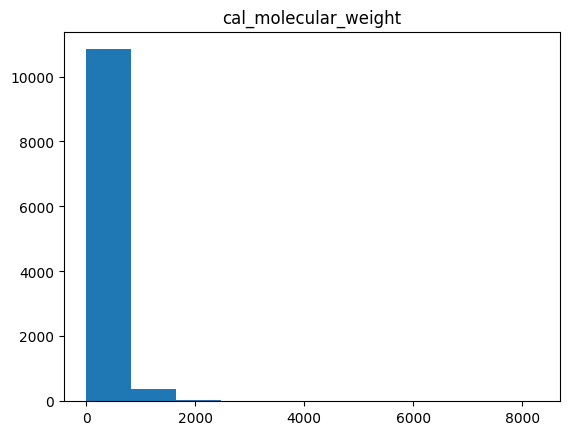

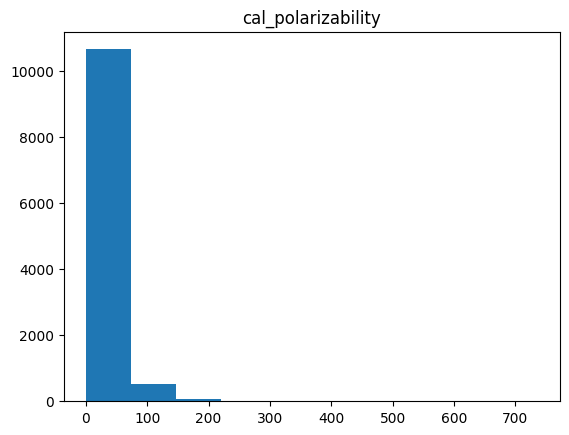

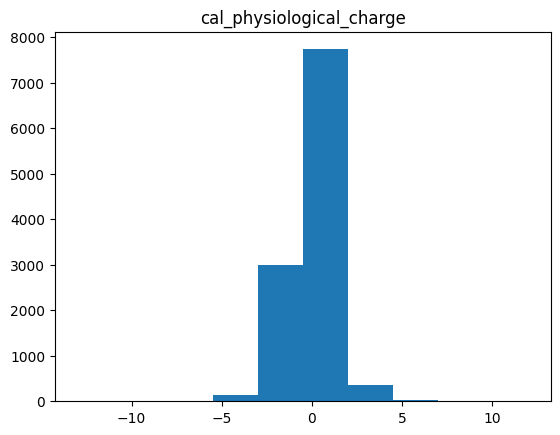

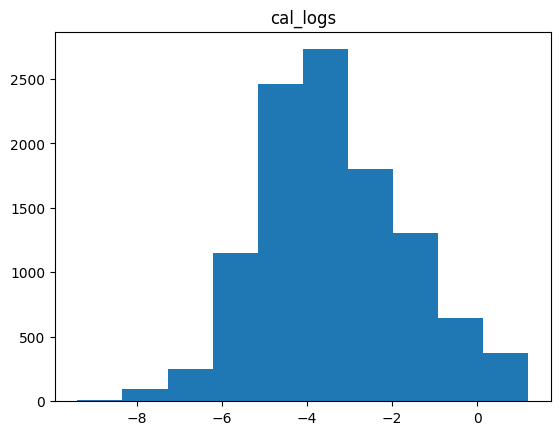

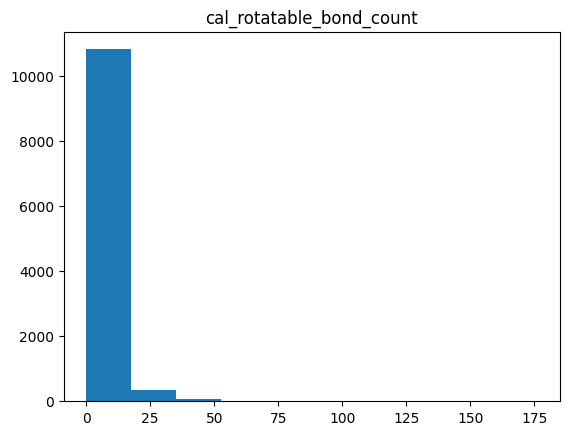

In [ ]:
for i in list(set(cols_to_analyse) - set(['state', 'cal_water_solubility'])):
    print(i)
    plt.figure()
    plt.hist(drugbank_df[i])
    plt.title(i)

In [ ]:
# Матрица графиков зависимости графиков друг от друга
sns.pairplot(drugbank_df[cols_to_analyse], size=3)
len(cols_to_analyse)

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-15-8ec46f3121c6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr=drugbank_df[cols_to_analyse].corr()


<Axes: >

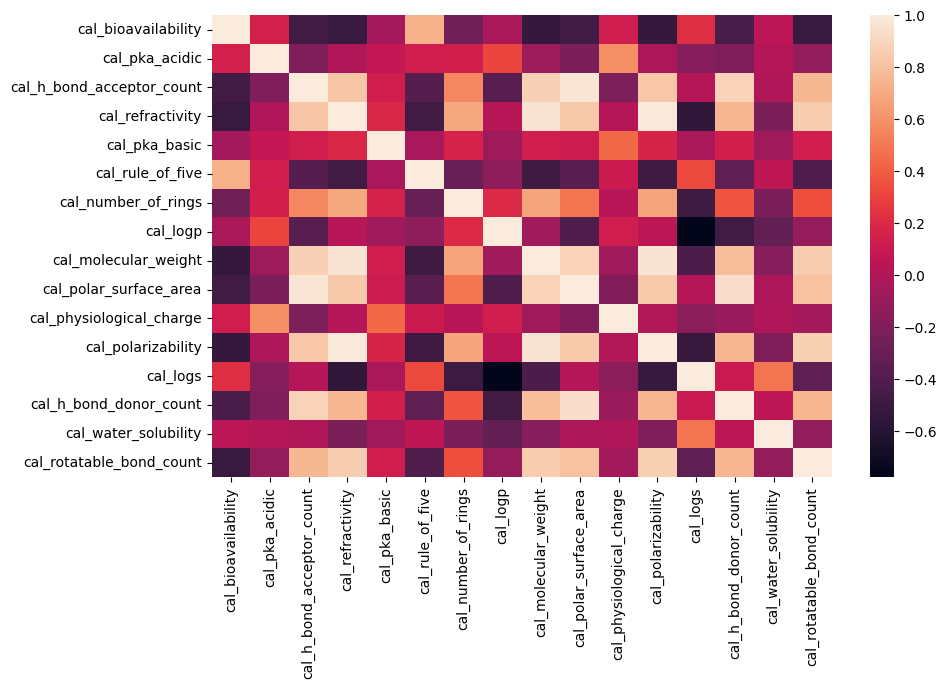

In [ ]:
# Корреляционная матрица
data_corr=drugbank_df[cols_to_analyse].corr()

plt.figure(figsize = (10,6))
sns.heatmap(data_corr)

## Предобработка данных


In [ ]:
# убрать текст из столбцов
drugbank_df = drugbank_df.replace('No pharmacokinetic data available. ', np.nan)
## Extract value from water solubility (e.g. '5.12e-04 g/l')
# drugbank_df['cal_water_solubility'] = drugbank_df.cal_water_solubility.str.replace(' g/l','').astype(float)

In [ ]:
# убрать ненужные, нерепрезентативные стобцы
df = drugbank_df.drop(['type', 'drugbank_id', 'name', 'half_life', 'exp_pka', 'exp_logp', 'exp_molecular_weight'], axis=1)
df

,state,cal_logp,cal_logs,cal_water_solubility,cal_molecular_weight,cal_polar_surface_area,cal_refractivity,cal_polarizability,cal_rotatable_bond_count,cal_h_bond_acceptor_count,cal_h_bond_donor_count,cal_pka_acidic,cal_pka_basic,cal_physiological_charge,cal_number_of_rings,cal_bioavailability,cal_rule_of_five
0,liquid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,liquid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,liquid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,liquid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,liquid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14592,NaN,4.74,-4.5,0.0115,353.466,63.25,107.0,40.31,8.0,4.0,2.0,18.99,4.77,0.0,3.0,1.0,1.0


In [ ]:
# # замена категориальных свойств на численные
# df['state'] = df['state'].astype('category').cat.codes
# df['state'] = df['state'].replace(0, np.nan)
# df
# df['state'].unique()
df['state'] = df['state'].replace('liquid', -1)
df['state'] = df['state'].replace('solid', 2)
df['state'] = df['state'].replace('gas', 1)
df['state'] = df['state'].replace(np.nan, 0)
df.state.unique()

array([-1.,  2.,  1.,  0.])

<Axes: >

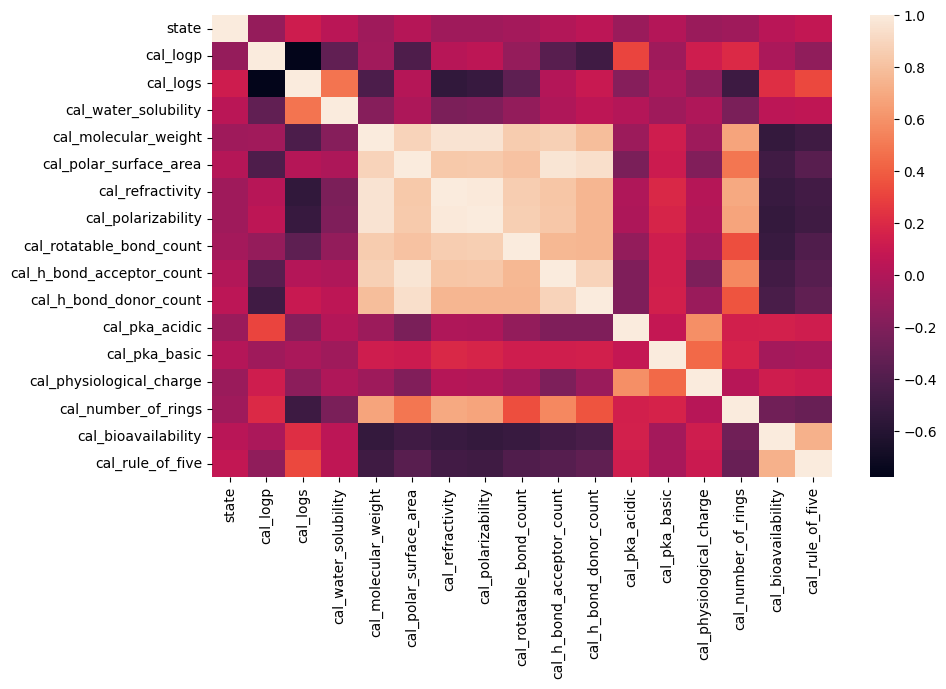

In [ ]:
data_corr=df.corr()

plt.figure(figsize = (10,6))
sns.heatmap(data_corr)

<Axes: >

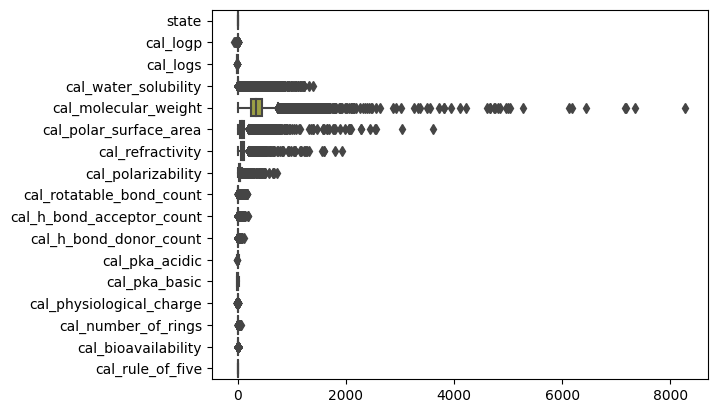

In [ ]:
# проверяем выбросы
sns.boxplot(data=df, orient="h")

In [ ]:
#удаляем выбросы
#в данном исследовании не используем, тк удаляет все значения таргетной переменной с NaN

# LIMIT = 1000
# for col in cols:
#   Q1 = df[col].quantile(0.25)
#   Q3 = df[col].quantile(0.75)
#   IQR = Q3 - Q1    #IQR is interquartile range.
#   filter = (df[col] >= Q1 - LIMIT * IQR) & (df[col] <= Q3 + LIMIT *IQR)
#   df.loc[~filter] = np.nan
# sns.boxplot(data=df, orient="h")

<Axes: >

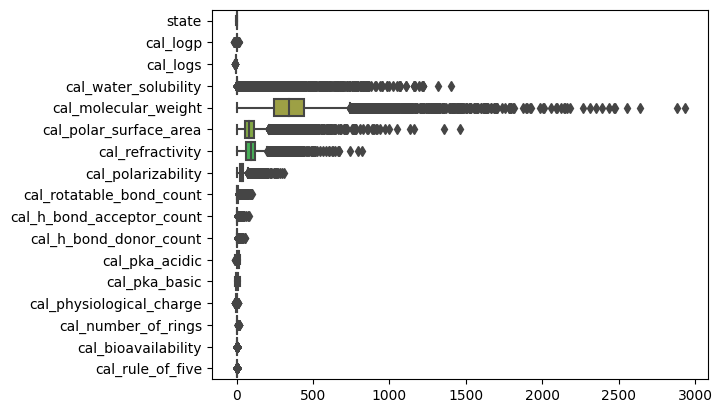

In [ ]:
# удаление выбросов мол веса
df = df[df.cal_molecular_weight < 3000]
sns.boxplot(data=df, orient="h")

In [ ]:
df['cal_pka_acidic'].isna().sum()

1796

In [ ]:
# Убираем те, что слишком друг с другом коррелируют, чтобы избежать переобучения
df = df.drop([''], axis=1)

state
cal_logp
cal_logs
cal_water_solubility
cal_molecular_weight
cal_polar_surface_area
cal_refractivity
cal_polarizability
cal_rotatable_bond_count
cal_h_bond_acceptor_count
cal_h_bond_donor_count
cal_pka_acidic
cal_pka_basic
cal_physiological_charge
cal_number_of_rings
cal_bioavailability
cal_rule_of_five


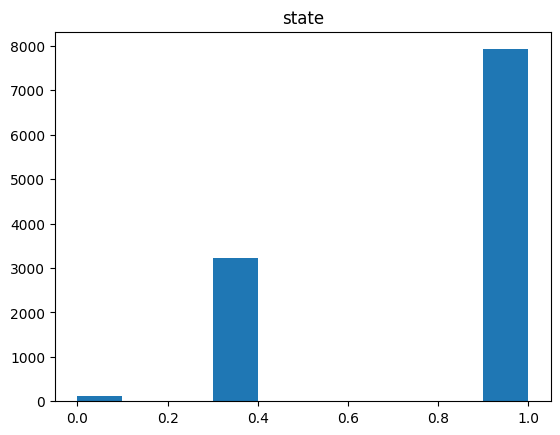

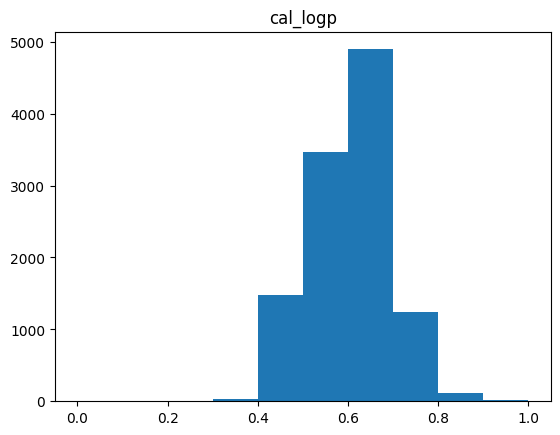

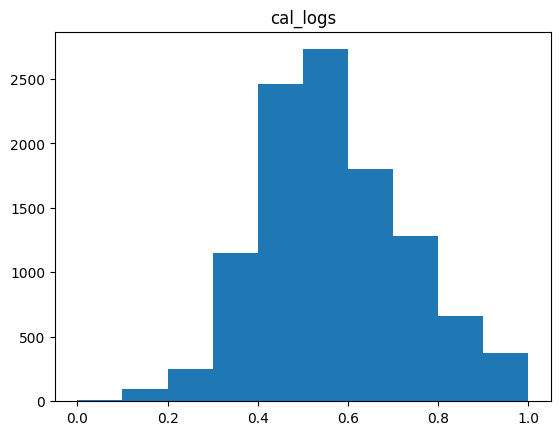

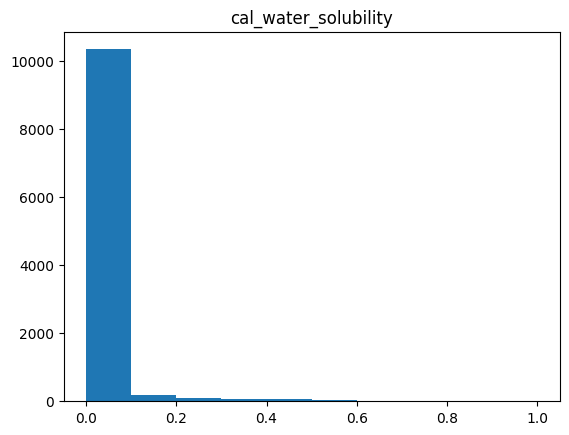

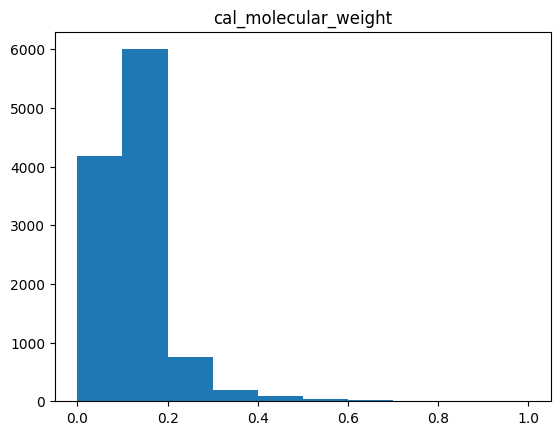

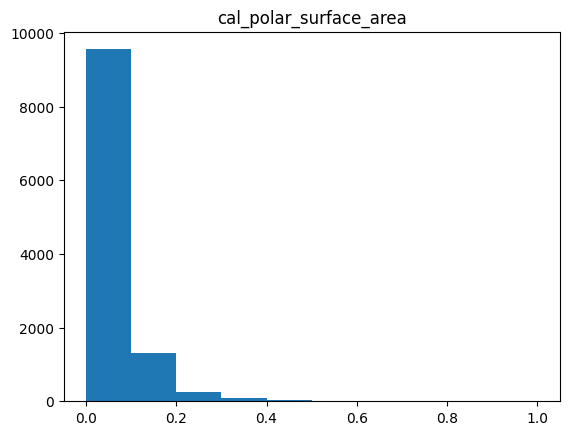

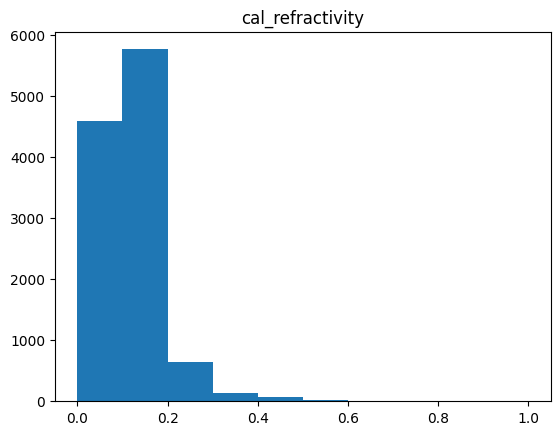

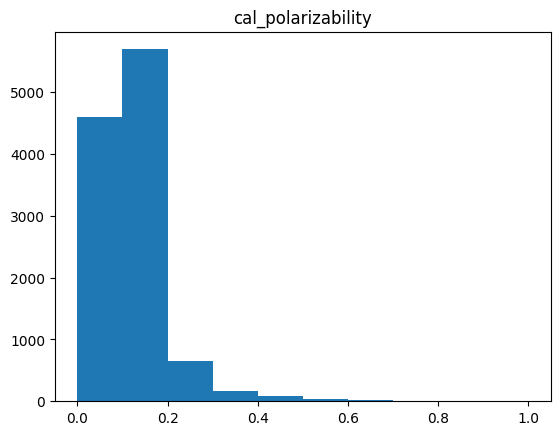

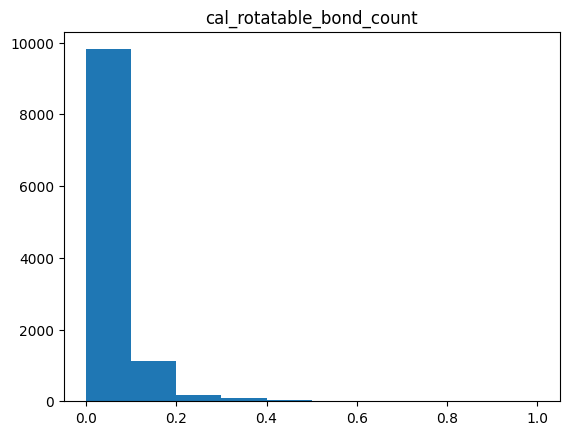

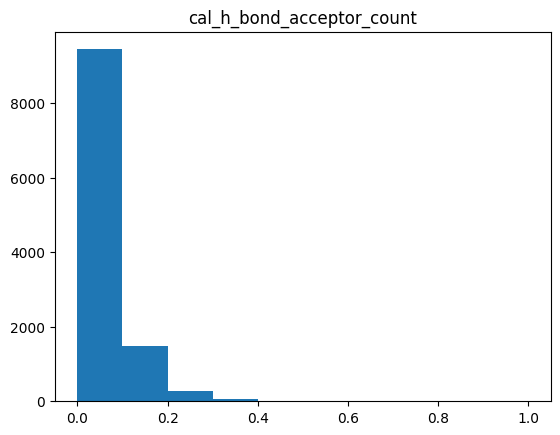

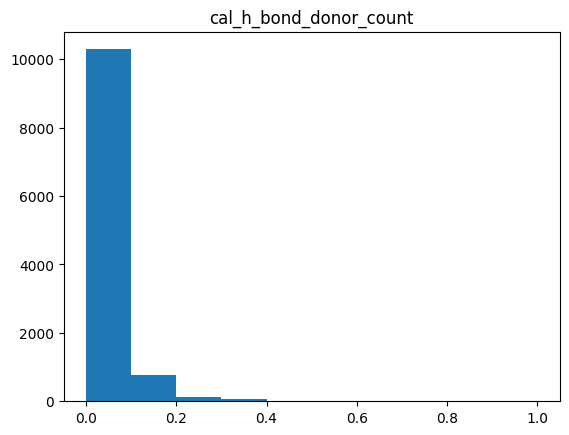

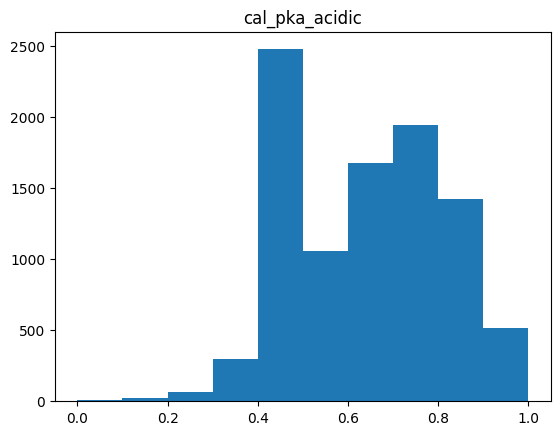

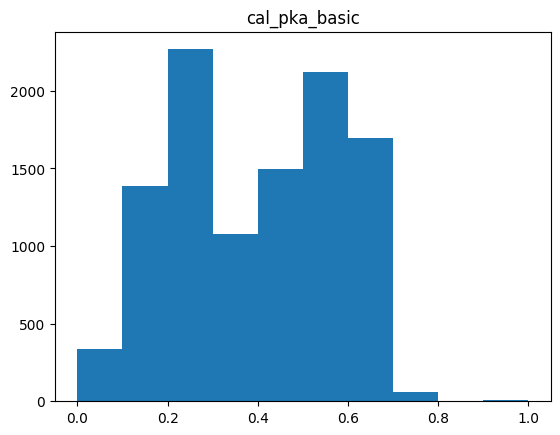

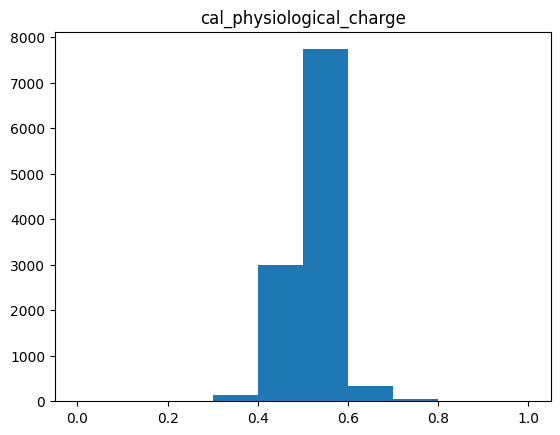

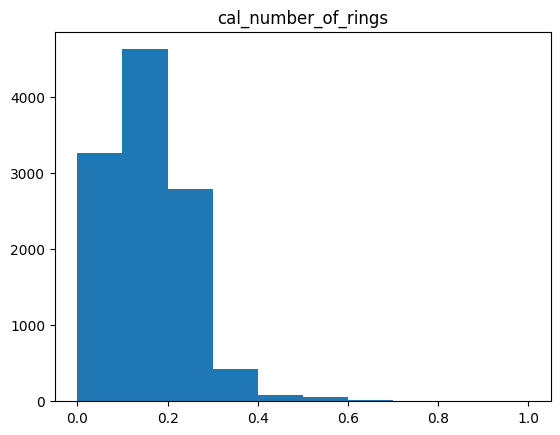

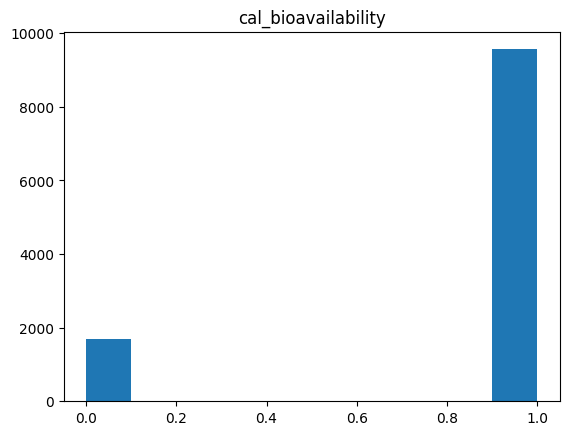

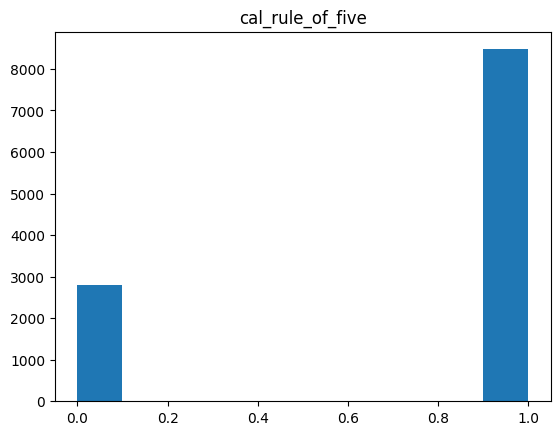

In [ ]:
# стандартизация и нормализация
# идеал для нормального StandardScaler, для остальных MinMaxScaler, тут сделаем для всех
x = df.values
cols = df.columns
# cols
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=cols)
df

for i in cols:
    print(i)
    plt.figure()
    plt.hist(df[i])
    plt.title(i)

In [ ]:
df.describe()

,state,cal_logp,cal_logs,cal_water_solubility,cal_molecular_weight,cal_polar_surface_area,cal_refractivity,cal_polarizability,cal_rotatable_bond_count,cal_h_bond_acceptor_count,cal_h_bond_donor_count,cal_pka_acidic,cal_pka_basic,cal_physiological_charge,cal_number_of_rings,cal_bioavailability,cal_rule_of_five
count,11270.000000,11266.000000,10812.000000,10812.000000,11270.000000,11265.000000,11265.000000,11263.000000,11265.000000,11265.000000,11265.000000,9474.000000,10452.000000,11263.000000,11265.000000,11265.000000,11270.000000
mean,0.798610,0.605478,0.567463,0.017131,0.127823,0.068196,0.118875,0.120330,0.059945,0.065952,0.046495,0.640050,0.398165,0.540579,0.145633,0.848913,0.751642
std,0.311944,0.087553,0.163987,0.075699,0.077916,0.060259,0.071952,0.076006,0.064742,0.053500,0.055134,0.169684,0.180130,0.053560,0.102017,0.358150,0.432080
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.543584,0.452830,0.000008,0.083306,0.036227,0.075495,0.075103,0.029412,0.037975,0.018182,0.485312,0.222920,0.500000,0.055556,1.000000,1.000000
50%,1.000000,0.613587,0.547170,0.000060,0.116293,0.056766,0.111868,0.112169,0.049020,0.050633,0.036364,0.663125,0.411774,0.545455,0.166667,1.000000,1.000000
75%,1.000000,0.666427,0.679245,0.001330,0.150753,0.079564,0.144109,0.144670,0.078431,0.075949,0.054545,0.772500,0.575824,0.590909,0.222222,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# работа с NaN
# в нашем случае удаляем все строки, их содержащие, кроме таргетной переменной
cols_to_delete_nan = list(set(df.columns) - set(['cal_pka_acidic']))
df = df.dropna(subset=cols_to_delete_nan)
df

,state,cal_logp,cal_logs,cal_water_solubility,cal_molecular_weight,cal_polar_surface_area,cal_refractivity,cal_polarizability,cal_rotatable_bond_count,cal_h_bond_acceptor_count,cal_h_bond_donor_count,cal_pka_acidic,cal_pka_basic,cal_physiological_charge,cal_number_of_rings,cal_bioavailability,cal_rule_of_five
0,1.000000,0.511862,0.443396,0.000033,0.743063,0.617057,0.664055,0.706031,0.647059,0.468354,0.509091,0.461875,0.686970,0.363636,0.333333,0.0,0.0
1,1.000000,0.576564,0.452830,0.000024,0.411869,0.293646,0.399951,0.404001,0.313725,0.202532,0.290909,0.671563,0.688226,0.590909,0.333333,0.0,0.0
2,1.000000,0.549964,0.452830,0.000020,0.432340,0.339400,0.398240,0.423360,0.323529,0.227848,0.309091,0.664687,0.653689,0.636364,0.333333,0.0,0.0
4,1.000000,0.503235,0.509434,0.000079,0.364050,0.298006,0.341946,0.337768,0.186275,0.189873,0.254545,0.671875,0.683516,0.590909,0.222222,0.0,0.0
5,1.000000,0.586988,0.386792,0.000005,0.487476,0.339249,0.469518,0.480690,0.372549,0.227848,0.309091,0.671875,0.684144,0.590909,0.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11264,0.333333,0.668943,0.433962,0.000004,0.119469,0.037726,0.100782,0.089314,0.058824,0.037975,0.018182,0.493750,0.387755,0.500000,0.111111,1.0,1.0
11265,0.333333,0.597771,0.594340,0.000233,0.135539,0.060695,0.112039,0.111715,0.049020,0.050633,0.036364,0.796250,0.591523,0.590909,0.166667,1.0,1.0
11266,0.333333,0.560388,0.424528,0.000007,0.226423,0.173741,0.210303,0.224046,0.176471,0.126582,0.127273,0.740312,0.659027,0.590909,0.166667,0.0,0.0
11268,1.000000,0.531632,0.613208,0.000456,0.180242,0.125496,0.159154,0.179632,0.127451,0.126582,0.109091,0.773438,0.295447,0.545455,0.166667,0.0,0.0


In [ ]:
df.shape

(10179, 17)

In [ ]:
df.isna().sum()

state                           0
cal_logp                        0
cal_logs                        0
cal_water_solubility            0
cal_molecular_weight            0
cal_polar_surface_area          0
cal_refractivity                0
cal_polarizability              0
cal_rotatable_bond_count        0
cal_h_bond_acceptor_count       0
cal_h_bond_donor_count          0
cal_pka_acidic               1544
cal_pka_basic                   0
cal_physiological_charge        0
cal_number_of_rings             0
cal_bioavailability             0
cal_rule_of_five                0
dtype: int64

##Обучение моделей

In [ ]:
# #разделение датасетов

# col_y = 'cal_pka_acidic'
# cols_X = list(set(df.columns) - set([col_y]))
# cols_X_sub = ['cal_logp','cal_water_solubility','cal_molecular_weight']

# train = df[~df['cal_pka_acidic'].isna()]
# test = df[df['cal_pka_acidic'].isna()]

# # print(test.shape, train.shape)

# y_train = train[col_y]
# X_train = train[cols_X]
# X_train_sub = train[cols_X_sub]

# y_test = test[col_y]
# X_test = test[cols_X]
# X_test_sub = test[cols_X_sub]

# y_test
# # test

In [ ]:
from sklearn.model_selection import train_test_split

train = df[~df['cal_pka_acidic'].isna()]
test = df[df['cal_pka_acidic'].isna()]

col_y = 'cal_pka_acidic'
cols_X = list(set(df.columns) - set([col_y]))

X_train, X_test, y_train, y_test = train_test_split(train[cols_X], train[col_y], test_size = 0.2,random_state=42)

###Самые популярные модели регрессии

In [ ]:
# #популярные модели
# #Linear Regression
# from sklearn.linear_model import LinearRegression

# #Kernel Ridge Regression
# from sklearn.kernel_ridge import KernelRidge

# #Bayesian Ridge Regression
# from sklearn.linear_model import BayesianRidge

# #Gradient Boosting Regression
# from sklearn.ensemble import GradientBoostingRegressor

# #Support Vector Machine
# from sklearn.svm import SVR

# #Stochastic Gradient Descent Regression
# from sklearn.linear_model import SGDRegressor

# #LGBM Regressor
# from lightgbm import LGBMRegressor

# #Elastic Net Regression
# from sklearn.linear_model import ElasticNet

# #XGBoost Regressor
# from xgboost.sklearn import XGBRegressor

#CatBoost Regressor
!pip install catboost
from catboost import CatBoostRegressor


In [ ]:
!pip install scikit-learn

In [ ]:
model = CatBoostRegressor(iterations=1000, l2_leaf_reg=30)

model.fit(X_train, y_train)

y_train_pred = model_cat.predict(X_train)
y_test_pred = model_cat.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2_score = r2_score(y_test, y_test_pred)


print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Accuracy: {r2_score:.2f}')

Mean absolute error: 0.05
Mean squared error: 0.00
Root mean squared error: 0.06
Accuracy: 0.85


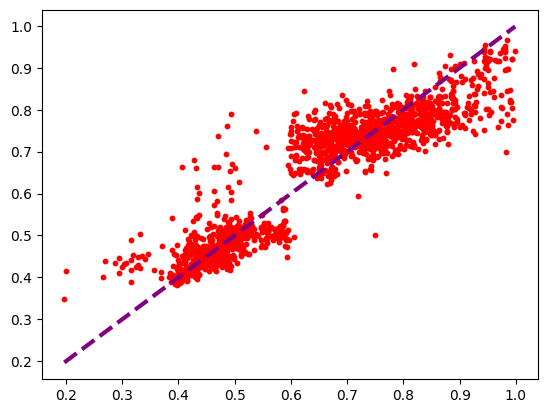

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

# ax1.scatter(y_train, y_train_pred, s=10, c='b', marker="s", label='first')
plt.scatter(y_test, y_test_pred, s=10, c='r', marker="o")
# plt.legend(loc='upper left')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="purple", linewidth=3, linestyle="--")

plt.show()

In [ ]:
# train = df[~df['cal_pka_acidic'].isna()]
# test = df[df['cal_pka_acidic'].isna()]

# col_y = 'cal_pka_acidic'
# cols_X = list(set(df.columns) - set([col_y]))
# cols_X_sub = ['cal_logp','cal_water_solubility','cal_molecular_weight']

# X_train_sub, X_test, y_train, y_test = train_test_split(train[cols_X_sub], train[col_y], test_size = 0.2,random_state=42)

In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# mae = mean_absolute_error(y_test, y_test_pred)
# mse = mean_squared_error(y_test, y_test_pred)
# rmse = np.sqrt(mse)
# r2_score = r2_score(y_test, y_test_pred)


# print(f'Mean absolute error: {mae:.2f}')
# print(f'Mean squared error: {mse:.2f}')
# print(f'Root mean squared error: {rmse:.2f}')
# print(f'Accuracy: {r2_score:.2f}')

### Задание:
1. обучение модели train + валидация
2. предсказание test
3. метрика качества
4. фитча импортанс
5. *то же самое для _sub, какой датасет лучше?
6. grid search
7. обратная стандартизация таргетной переменной

###LinearRegression
самая простая

In [ ]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


regressor = LinearRegression()
model = regressor.fit(X_train, y_train)

# Perform 6-fold cross validation
scores = cross_val_score(lm, X, y, cv=6)
print("Cross-validated scores:", scores)

predictions = cross_val_predict(model, df, y, cv=6)

In [ ]:


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score = r2_score(y_test, y_pred)

print(regressor.intercept_)
print(regressor.coef_)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Accuracy: {r2_score:.2f}')

In [ ]:
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### Рандомный лес

на всех свойствах

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


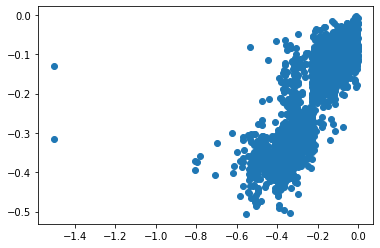

In [ ]:
regr = RandomForestRegressor(random_state=0, n_estimators=100, oob_score = True)
regr.fit(X_train, y_train)

plt.scatter(np.log10(y_train), np.log10(regr.oob_prediction_))
plt.show()

In [ ]:
predicted = regr.predict(X_test)
predicted

array([0.41748437, 0.67393125, 0.66535937, ..., 0.71811875, 0.76264688,
       0.8848125 ])

SyntaxError: ignored

In [ ]:
min_max_scaler.inverse_transform(predicted)

ValueError: ignored

на лучших свойствах

In [ ]:
# Build random forest model
y = complete_data_df.loc[:,'half_life_hours_curated']
X = complete_data_df.iloc[:, :-1]
regr = RandomForestRegressor(random_state=0, n_estimators=1000, oob_score = True)
regr.fit(X, y)
# plot actual half-life vs out-of-bag prediction
plt.scatter(np.log10(y), np.log10(regr.oob_prediction_))
plt.show()

In [ ]:
#